In [14]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

# 1

In [15]:
df_price = pd.read_csv('DailyPrices.csv')
df_price

,Date,SPY,AAPL,NVDA,MSFT,AMZN,META,GOOGL,AVGO,TSLA,...,SBUX,MMC,MDT,CB,LMT,KKR,MU,PLD,LRCX,EQIX
0,2023-01-03,370.367920,123.768456,14.304595,236.183502,85.820000,124.265305,88.798103,53.397118,108.099998,...,96.842888,161.264664,73.835571,214.210434,455.904877,45.874386,49.810677,106.143532,35.568180,639.647766
1,2023-01-04,373.227142,125.045052,14.738281,225.852097,85.139999,126.885315,87.761856,54.049290,113.639999,...,100.329346,164.402908,76.392372,217.732574,454.921539,47.269882,53.598137,110.165482,36.268723,656.679016
2,2023-01-05,368.967438,123.718987,14.254632,219.158371,83.120003,126.456940,85.888649,53.545685,110.339996,...,100.300537,161.420135,75.505508,216.917526,455.465698,46.581966,54.102486,106.294243,35.805130,637.822998
3,2023-01-06,377.428589,128.271118,14.848200,221.741211,86.080002,129.525223,87.024529,56.768929,113.059998,...,102.471153,166.103210,76.288589,222.060059,451.809113,47.348503,56.139599,109.873489,38.226994,650.683350
4,2023-01-09,377.214661,128.795578,15.616640,223.900162,87.360001,128.977310,87.702065,55.655602,119.769997,...,100.598274,165.549393,73.156288,216.869034,438.204468,48.783306,55.734154,109.317757,38.841690,657.654114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,2024-12-27,595.010010,255.589996,137.009995,430.529999,223.750000,599.809998,192.759995,241.750000,431.660004,...,92.250000,213.470001,80.739998,277.679993,488.970001,149.860001,88.514999,105.239998,73.400002,942.659973
500,2024-12-30,588.219971,252.199997,137.490005,424.829987,221.300003,591.239990,191.240005,235.580002,417.410004,...,90.580002,211.979996,79.610001,275.410004,483.369995,148.389999,85.309998,105.099998,72.150002,935.929993
501,2024-12-31,586.080017,250.419998,134.289993,421.500000,219.389999,585.510010,189.300003,231.839996,403.839996,...,91.250000,212.410004,79.879997,276.299988,485.940002,147.910004,84.160004,105.699997,72.230003,942.890015
502,2025-01-02,584.640015,243.850006,138.309998,418.579987,220.220001,599.239990,189.429993,231.979996,379.279999,...,92.169998,211.339996,80.220001,272.519989,482.250000,149.190002,87.330002,104.260002,72.440002,944.229980


In [16]:
df_pf = pd.read_csv('initial_portfolio.csv')
df_pf

,Portfolio,Symbol,Holding
0,A,WFC,142.0
1,A,ETN,30.0
2,A,AMZN,46.0
3,A,QCOM,64.0
4,A,LMT,21.0
...,...,...,...
94,C,MSFT,24.0
95,C,PEP,68.0
96,C,CB,38.0
97,C,PANW,56.0


In [17]:
df_rf = pd.read_csv('rf.csv')
df_rf

,Date,rf
0,2023-01-04,0.000150
1,2023-01-05,0.000250
2,2023-01-06,0.000100
3,2023-01-09,0.000000
4,2023-01-10,0.000349
...,...,...
498,2024-12-27,0.000363
499,2024-12-30,0.000181
500,2024-12-31,0.000635
501,2025-01-02,0.000453


In [18]:
# Filter data by the end of 2023
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_rf['Date'] = pd.to_datetime(df_rf['Date'])
df_price.set_index('Date', inplace=True)
df_rf.set_index('Date', inplace=True)

In [19]:
portfolios = {portfolio: data for portfolio, data in df_pf.groupby('Portfolio')}
portfolios['all'] = df_pf

In [20]:
pf_names = df_pf['Portfolio'].unique().tolist()
pf_names.append('all')

all_capm_results = []  # Initialize a list to store CAPM results for all portfolios

for pf_name in pf_names:
    print("\n", pf_name)
    pf = portfolios[pf_name]
    # Stock names
    pf_stocks = pf['Symbol'].copy()

    # Get the closing prices of the stocks in the portfolio on 2024-01-02
    closing_prices = df_price.loc['2023-12-29', pf_stocks].copy()

    # Calculate the total value of the portfolio
    holdings = pf.set_index('Symbol')['Holding']
    portfolio_value = (closing_prices * holdings).sum()

    # Calculate the weights of each stock in the portfolio
    current_weights = (closing_prices * holdings) / portfolio_value
    
    df_pf_price = df_price[list(pf_stocks)+['SPY']].copy()
    returns = np.log(df_pf_price / df_pf_price.shift(1)).dropna()
    excess_returns = returns.subtract(df_rf['rf'], axis=0)
    excess_returns_mkt = returns['SPY'].subtract(df_rf['rf'], axis=0)

    # Recalculate daily returns
    returns_hist = returns.loc[returns.index <= '2023-12-31'].copy()

    # Calculate excess returns
    excess_returns_hist = excess_returns.loc[returns.index <= '2023-12-31'].copy()
    excess_return_mkt_hist = excess_returns_mkt.loc[excess_returns_mkt.index <= '2023-12-31'].copy()

    # Calculate the error term for each stock
    # Perform CAPM regression for each stock
    reg_results = []
    X = excess_return_mkt_hist.values
    X = sm.add_constant(X)
    for stock in returns_hist.columns:
        if stock not in ['SPY', 'rf']:
            y = excess_returns_hist[stock].values
            model = sm.OLS(y, X).fit()
            alpha = model.params[0]
            beta = model.params[1]
            resid_std = np.std(model.resid)
            reg_results.append({
                "Symbol": stock,
                "Alpha": alpha,
                "Beta": beta,
                "ResidualStd": resid_std
            })
    
    capm_results = pd.DataFrame(reg_results)
    all_capm_results.append(capm_results)  # Append the results for the current portfolio
    
    start_date = '2024-01-02'
    df_pf_returns_holding_ar = df_price[list(pf_stocks)].pct_change().dropna().copy()
    df_pf_returns_holding_ar = df_pf_returns_holding_ar.loc[df_pf_returns_holding_ar.index >= start_date].copy()
    df_pf_returns_holding_log = returns[list(pf_stocks)].loc[returns.index >= start_date].copy()
    pf_excess_returns = excess_returns.loc[excess_returns.index >= start_date].copy()
    df_rf_holding = df_rf.loc[df_rf.index >= start_date].copy()
    mkt_premium_holding = excess_returns_mkt.loc[excess_returns_mkt.index >= start_date].copy()
    
    
    
    # Ex-post attribution
    weights = {}
    factor_weights = {}
    portfolio_returns = {}
    resid_returns = {}
    resid_returns_stocks = {}
    current_weights = current_weights.values
    for date in df_pf_returns_holding_ar.index:
        # Calculate portfolio return for the day
        weights[date] = current_weights
        weighted_betas = capm_results['Beta'].values * current_weights
        factor_weight = np.sum(weighted_betas)
        factor_weights[date] = factor_weight
        daily_returns = df_pf_returns_holding_ar.loc[date, :].values
        weighted_returns = current_weights * (1 + daily_returns)
        pf_return = np.sum(weighted_returns)
        portfolio_returns[date] = pf_return - 1
        resid_returns[date] = (pf_return - 1) - factor_weight * mkt_premium_holding[date]
        resid_stocks = current_weights * daily_returns - weighted_betas * mkt_premium_holding[date]
        resid_returns_stocks[date] = resid_stocks
        current_weights = weighted_returns / pf_return
    resid_returns_stocks = pd.DataFrame.from_dict(resid_returns_stocks, orient='index', columns=pf_stocks)

    df_weights = pd.DataFrame(weights, index=pf_stocks).T
    df_factor_weights = pd.DataFrame.from_dict(factor_weights, orient='index', columns=['excess_return'])
    df_portfolio_returns = pd.DataFrame(portfolio_returns.values(), index=portfolio_returns.keys(), columns=['returns'])
    df_resid_returns = pd.DataFrame.from_dict(resid_returns, orient='index', columns=['resid_return'])
    portfolio_returns = df_portfolio_returns['returns']
    log_total_return = np.sum(np.log1p(portfolio_returns))
    total_return = np.exp(log_total_return) - 1
    
    
    result = {}
    total_return_market = np.exp(np.sum(mkt_premium_holding))-1
    total_return_alpha = np.exp(np.sum(df_resid_returns.values))-1
    result["Total Return"] = [total_return_market, total_return_alpha, total_return]
    
    K = log_total_return / total_return
    k_t = np.log1p(portfolio_returns) / portfolio_returns / K

    
    
    attr_matrix = mkt_premium_holding.values * df_factor_weights.values.T * k_t.values
    factor_return_attr = attr_matrix.sum(axis=1)[0]
    resid_return_attr = (df_resid_returns.values.T * k_t.values).sum(axis=1)[0]
    resid_return_stock_attr = resid_returns_stocks.mul(k_t.values, axis=0)
    # print the alpha of each stock
    # display(np.sum(resid_return_stock_attr, axis=0))

    result['Return Attribution'] = [factor_return_attr, resid_return_attr, factor_return_attr+resid_return_attr]
    
    # Volatility
    # Factors
    # SPY
    y = (mkt_premium_holding.values * df_factor_weights.values.T).flatten()
    X = portfolio_returns
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    component_sd = []
    component_sd.append(model.params.iloc[1])
    # Alpha
    y = df_resid_returns.values.flatten()
    model = sm.OLS(y, X).fit()
    component_sd.append(model.params.iloc[1])
    pf_vol = portfolio_returns.std()
    factor_vol_attr = component_sd[0] * pf_vol
    resid_vol_attr = component_sd[1] * pf_vol
    
    result['Vol Attribution'] = [factor_vol_attr, resid_vol_attr, pf_vol]
    result_df = pd.DataFrame.from_dict(result, orient='index', columns=['SPY', 'Alpha', 'Portfoliio'])
    display(result_df)




 A


,SPY,Alpha,Portfoliio
Total Return,0.198692,-0.040118,0.136642
Return Attribution,0.180666,-0.044024,0.136642
Vol Attribution,0.007062,0.000356,0.007418



 B


,SPY,Alpha,Portfoliio
Total Return,0.198692,0.026941,0.203526
Return Attribution,0.174776,0.028750,0.203526
Vol Attribution,0.006400,0.000468,0.006867



 C


,SPY,Alpha,Portfoliio
Total Return,0.198692,0.084743,0.281172
Return Attribution,0.189702,0.091471,0.281172
Vol Attribution,0.007224,0.000700,0.007924



 all


,SPY,Alpha,Portfoliio
Total Return,0.198692,0.021141,0.204731
Return Attribution,0.181629,0.023102,0.204731
Vol Attribution,0.007203,-0.000113,0.007090


# 2

In [21]:
all_capm_results_df = pd.concat(all_capm_results, ignore_index=True)
all_capm_results_df = all_capm_results_df.drop_duplicates(subset=['Symbol'])
all_capm_results_df

,Symbol,Alpha,Beta,ResidualStd
0,WFC,-2.786976e-04,1.144627,0.014701
1,ETN,7.318968e-04,1.117638,0.013899
2,AMZN,9.409601e-04,1.534187,0.016383
3,QCOM,-4.403113e-07,1.475888,0.015558
4,LMT,-5.413857e-04,0.321020,0.010969
...,...,...,...,...
94,MSFT,7.695527e-04,1.166812,0.012441
95,PEP,-5.877193e-04,0.376862,0.008975
96,CB,-3.810986e-04,0.458951,0.012284
97,PANW,1.953089e-03,1.175995,0.021732


In [22]:
from scipy.optimize import minimize

def sharpe_ratio(weights, mu, cov, rf):
    port_return = np.dot(weights, mu)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return (port_return - rf) / port_vol  # Negative for minimization

returns = np.log(df_price / df_price.shift(1)).dropna()


for pf_name in pf_names:
    pf_stocks = list(portfolios[pf_name]['Symbol'].copy())
    capm_results = all_capm_results_df.loc[all_capm_results_df['Symbol'].isin(pf_stocks)].copy()
    stock_returns = returns[pf_stocks].copy()
    market_return_hist = returns['SPY'].loc[returns.index <= '2023-12-31'].copy()
    stock_returns_hist = stock_returns.loc[stock_returns.index <= '2023-12-31'].copy()
    rf_hist = df_rf.loc[df_rf.index <= '2023-12-31'].copy()
    
    market_avg_return = np.average(market_return_hist)
    avg_rf = np.average(rf_hist)
    
    # Calculate expected return of stocks using CAPM results
    stock_exp_return = {}
    for stock in pf_stocks:
        if stock != 'SPY':
            stock_beta = all_capm_results_df.loc[all_capm_results_df['Symbol'] == stock, 'Beta'].values[0]
            stock_exp_return[stock] = stock_beta * (market_avg_return - avg_rf)
    stock_exp_return = pd.DataFrame.from_dict(stock_exp_return, orient='index', columns=['Expected Return'])
    
    # Calculate the covariance matrix of stock returns
    cov_matrix = stock_returns_hist.cov()
    
    num_stocks = len(pf_stocks)
    
    # Define the optimization function to minimize the Sharpe Ratio
    def negative_sharpe_ratio(weights, mu, cov, rf):
        return -sharpe_ratio(weights, mu, cov, rf)

    # Constraints: weights must sum to 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # Bounds: weights must be between 0 and 1
    bounds = [(0, 1) for _ in range(num_stocks)]

    # Initial guess: equal weights
    initial_weights = np.array([1 / num_stocks] * num_stocks)

    # Optimize the portfolio
    result = minimize(negative_sharpe_ratio, initial_weights, args=(stock_exp_return.values, cov_matrix.values, avg_rf),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    # Extract the optimized weights and calculate the Sharpe Ratio
    optimized_weights = result.x
    optimized_sharpe_ratio = -result.fun

    print(f"Optimized Weights for {pf_name}: {optimized_weights}")
    print(f"Lowest Sharpe Ratio for {pf_name}: {optimized_sharpe_ratio:.4f}")
    
    excess_returns = returns.subtract(df_rf['rf'], axis=0)
    excess_returns_mkt = returns['SPY'].subtract(df_rf['rf'], axis=0)
    start_date = '2024-01-02'
    df_pf_returns_holding_ar = df_price[pf_stocks].pct_change().dropna().copy()
    df_pf_returns_holding_ar = df_pf_returns_holding_ar.loc[df_pf_returns_holding_ar.index >= start_date].copy()
    df_pf_returns_holding_log = stock_returns.loc[returns.index >= start_date].copy()
    pf_excess_returns = excess_returns.loc[excess_returns.index >= start_date].copy()
    df_rf_holding = df_rf.loc[df_rf.index >= start_date].copy()
    mkt_premium_holding = excess_returns_mkt.loc[excess_returns_mkt.index >= start_date].copy()
    
    # Ex-post attribution
    weights = {}
    factor_weights = {}
    portfolio_returns = {}
    resid_returns = {}
    resid_returns_stocks = {}
    resid_returns_stocks_exp = {}
    current_weights = optimized_weights.copy()
    stock_vol_exp = current_weights * capm_results['ResidualStd']
    
    for date in df_pf_returns_holding_ar.index:
        # Calculate portfolio return for the day
        weights[date] = current_weights
        weighted_betas = capm_results['Beta'].values * current_weights
        factor_weight = np.sum(weighted_betas)
        factor_weights[date] = factor_weight
        daily_returns = df_pf_returns_holding_ar.loc[date, :].values
        weighted_returns = current_weights * (1 + daily_returns)
        pf_return = np.sum(weighted_returns)
        portfolio_returns[date] = pf_return - 1
        resid_returns[date] = (pf_return - 1) - factor_weight * mkt_premium_holding[date]
        resid_stocks = current_weights * daily_returns - weighted_betas * mkt_premium_holding[date]
        resid_returns_stocks[date] = resid_stocks
        current_weights = weighted_returns / pf_return

    df_weights = pd.DataFrame(weights, index=pf_stocks).T
    df_factor_weights = pd.DataFrame.from_dict(factor_weights, orient='index', columns=['excess_return'])
    df_portfolio_returns = pd.DataFrame(portfolio_returns.values(), index=portfolio_returns.keys(), columns=['returns'])
    df_resid_returns = pd.DataFrame.from_dict(resid_returns, orient='index', columns=['resid_return'])
    resid_returns_stocks = pd.DataFrame.from_dict(resid_returns_stocks, orient='index', columns=pf_stocks)
    # display(df_resid_returns)
    # display(np.sum(resid_returns_stocks, axis=1))
    portfolio_returns = df_portfolio_returns['returns']
    log_total_return = np.sum(np.log1p(portfolio_returns))
    total_return = np.exp(log_total_return) - 1
    
    
    result = {}
    total_return_market = np.exp(np.sum(mkt_premium_holding))-1
    total_return_alpha = np.exp(np.sum(df_resid_returns.values))-1
    result["Total Return"] = [total_return_market, total_return_alpha, total_return]
    
    K = log_total_return / total_return
    k_t = np.log1p(portfolio_returns) / portfolio_returns / K

    
    
    attr_matrix = mkt_premium_holding.values * df_factor_weights.values.T * k_t.values
    factor_return_attr = attr_matrix.sum(axis=1)[0]
    resid_return_attr = (df_resid_returns.values.T * k_t.values).sum(axis=1)[0]
    resid_return_stock_attr = resid_returns_stocks.mul(k_t.values, axis=0)
    # print the alpha of each stock

    result['Return Attribution'] = [factor_return_attr, resid_return_attr, factor_return_attr+resid_return_attr]
    
    # Volatility
    # Factors
    # SPY
    y = (mkt_premium_holding.values * df_factor_weights.values.T).flatten()
    X = portfolio_returns
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    component_sd = []
    component_sd.append(model.params.iloc[1])
    # Alpha
    y = df_resid_returns.values.flatten()
    model = sm.OLS(y, X).fit()
    component_sd.append(model.params.iloc[1])
    pf_vol = portfolio_returns.std()
    factor_vol_attr = component_sd[0] * pf_vol
    resid_vol_attr = component_sd[1] * pf_vol
        
    # Individual stocks
    # Calculate volatility attribution for each stock
    vol_attribution = {}
    for stock in resid_returns_stocks.columns:
        y = resid_returns_stocks[stock].values
        model = sm.OLS(y, X).fit()
        vol_attribution[stock] = model.params[1] * pf_vol

    # Convert the results to a DataFrame
    vol_attribution_df = pd.DataFrame.from_dict(vol_attribution, orient='index', columns=['Volatility Attribution'])
    vol_attribution_df['Stock Volatility Expected'] = stock_vol_exp.values
    display(vol_attribution_df)
    
    result['Vol Attribution'] = [factor_vol_attr, resid_vol_attr, pf_vol]
    result_df = pd.DataFrame.from_dict(result, orient='index', columns=['SPY', 'Alpha', 'Portfoliio'])
    display(result_df)
    


Optimized Weights for A: [4.12813601e-04 5.53953448e-02 1.29397622e-01 3.62286898e-02
 0.00000000e+00 0.00000000e+00 8.13151629e-19 1.01455750e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.34639859e-02
 2.99255775e-02 0.00000000e+00 0.00000000e+00 1.67419096e-02
 1.11292254e-01 1.78893358e-18 8.67361738e-19 0.00000000e+00
 4.27364800e-02 2.79693723e-02 1.07693516e-01 7.56540923e-02
 4.49232586e-03 0.00000000e+00 5.42101086e-19 8.06554481e-02
 1.24683250e-18 1.62630326e-19 2.71050543e-19 7.68520340e-02
 9.63278427e-03]
Lowest Sharpe Ratio for A: 0.0691


/var/folders/z_/mrmcmc9j3nq9_m70z7783tyr0000gn/T/ipykernel_64891/3536065691.py:147: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vol_attribution[stock] = model.params[1] * pf_vol


,Volatility Attribution,Stock Volatility Expected
WFC,-9.838390e-07,6.068647e-06
ETN,3.134723e-04,7.699607e-04
AMZN,1.239093e-04,2.119941e-03
QCOM,2.304241e-04,5.636388e-04
LMT,0.000000e+00,0.000000e+00
KO,0.000000e+00,0.000000e+00
JNJ,-2.747486e-21,8.106133e-21
ISRG,3.394114e-05,1.528499e-03
XOM,0.000000e+00,0.000000e+00
MDT,0.000000e+00,0.000000e+00


,SPY,Alpha,Portfoliio
Total Return,0.198692,0.091511,0.387120
Return Attribution,0.285774,0.101346,0.387120
Vol Attribution,0.010561,0.001240,0.011801


Optimized Weights for B: [5.34522860e-02 6.26138268e-02 7.34397955e-02 3.63376324e-02
 3.53142264e-19 0.00000000e+00 5.54934731e-03 0.00000000e+00
 0.00000000e+00 3.34786251e-02 1.05112490e-01 5.42101086e-20
 4.64092602e-02 2.07659567e-02 7.05365222e-02 0.00000000e+00
 2.87313576e-18 4.14707331e-18 1.04631810e-01 1.51866688e-02
 0.00000000e+00 1.21945810e-01 0.00000000e+00 1.08710517e-01
 0.00000000e+00 0.00000000e+00 1.40946282e-18 3.36102673e-18
 5.69206141e-19 8.62188602e-02 3.26393427e-02 0.00000000e+00
 2.29712490e-02]
Lowest Sharpe Ratio for B: 0.0694


/var/folders/z_/mrmcmc9j3nq9_m70z7783tyr0000gn/T/ipykernel_64891/3536065691.py:147: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vol_attribution[stock] = model.params[1] * pf_vol


,Volatility Attribution,Stock Volatility Expected
AXP,-3.377670e-05,6.916751e-04
HON,-9.110081e-05,5.539887e-04
META,6.015893e-05,1.413209e-03
NFLX,1.161136e-05,7.452693e-04
PGR,-2.729195e-22,6.635891e-21
LLY,0.000000e+00,0.000000e+00
JPM,-1.375506e-06,6.024216e-05
VRTX,0.000000e+00,0.000000e+00
TJX,0.000000e+00,0.000000e+00
EQIX,-6.194404e-05,4.155628e-04


,SPY,Alpha,Portfoliio
Total Return,0.198692,-0.011335,0.234916
Return Attribution,0.247748,-0.012832,0.234916
Vol Attribution,0.009559,0.000109,0.009668


Optimized Weights for C: [2.18933032e-18 3.78032066e-02 2.47312347e-03 1.00384946e-01
 2.00403722e-02 5.17207663e-20 3.40603916e-18 0.00000000e+00
 4.36970861e-03 2.03605565e-02 1.55066027e-02 6.67991412e-02
 1.09860690e-01 0.00000000e+00 3.18271698e-02 0.00000000e+00
 5.75150772e-02 1.56054016e-18 6.98038039e-19 4.82905106e-02
 2.54096283e-02 3.98227572e-02 3.70767815e-02 1.18393776e-01
 9.87592420e-19 2.32107065e-02 0.00000000e+00 6.02615588e-02
 9.86586074e-02 3.95983997e-18 5.60865783e-03 0.00000000e+00
 7.63264214e-02]
Lowest Sharpe Ratio for C: 0.0696


/var/folders/z_/mrmcmc9j3nq9_m70z7783tyr0000gn/T/ipykernel_64891/3536065691.py:147: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vol_attribution[stock] = model.params[1] * pf_vol


,Volatility Attribution,Stock Volatility Expected
IBM,3.425221e-21,1.975907e-20
TXN,6.661777e-05,4.178255e-04
ADP,-7.106800e-06,2.782219e-05
GOOG,-9.152640e-05,1.542093e-03
ORCL,6.099004e-05,3.485064e-04
BSX,-1.922009e-23,6.091338e-22
UNH,-3.959772e-21,4.454083e-20
TMUS,0.000000e+00,0.000000e+00
SYK,-1.035564e-05,5.646786e-05
GS,4.736704e-05,2.521856e-04


,SPY,Alpha,Portfoliio
Total Return,0.198692,0.186446,0.489339
Return Attribution,0.282333,0.207006,0.489339
Vol Attribution,0.010079,0.001588,0.011667


/var/folders/z_/mrmcmc9j3nq9_m70z7783tyr0000gn/T/ipykernel_64891/3536065691.py:147: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vol_attribution[stock] = model.params[1] * pf_vol


Optimized Weights for all: [8.98549066e-03 1.59464503e-02 4.13643419e-02 2.14358093e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.53055928e-02
 4.96022494e-18 0.00000000e+00 0.00000000e+00 8.24407299e-02
 1.34955161e-02 0.00000000e+00 4.01154804e-18 2.19550940e-18
 3.76659165e-02 0.00000000e+00 7.22162493e-03 1.66696084e-18
 3.26253127e-02 0.00000000e+00 6.59170748e-02 3.76082629e-19
 1.05709712e-18 0.00000000e+00 0.00000000e+00 2.44961245e-02
 6.77626358e-19 0.00000000e+00 2.37169225e-18 8.04559656e-03
 8.05020113e-18 2.50721752e-18 3.07148191e-02 4.93429178e-02
 1.94572129e-02 2.68340038e-18 0.00000000e+00 9.48676901e-20
 0.00000000e+00 0.00000000e+00 2.81892565e-18 7.95034493e-02
 0.00000000e+00 2.47471712e-02 1.23099507e-02 0.00000000e+00
 5.96311195e-19 4.17417836e-18 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.93052717e-02 0.00000000e+00
 8.90343497e-02 0.00000000e+00 1.04354459e-18 0.00000000e+00
 1.93801138e-18 0.00000000e+00 5.27748483e-04 9.77659362e-

,Volatility Attribution,Stock Volatility Expected
WFC,-1.920314e-05,1.320930e-04
ETN,8.147386e-05,2.216457e-04
AMZN,4.092879e-05,6.776782e-04
QCOM,1.085193e-05,3.334941e-05
LMT,0.000000e+00,0.000000e+00
...,...,...
MSFT,8.409182e-06,2.178532e-04
PEP,-9.783155e-22,2.676082e-21
CB,-4.511542e-21,2.580499e-20
PANW,2.818009e-21,3.151394e-20


,SPY,Alpha,Portfoliio
Total Return,0.198692,0.057423,0.349998
Return Attribution,0.284538,0.065460,0.349998
Vol Attribution,0.011005,-0.000233,0.010772


# 3

## Inverse Gaussian Distribution

Inverse Gaussian Distribution is controlled by two factors $\mu$ and $\lambda$. The distribution got its name as the inverse of Gaussian distribution. It has a close relationship with brownian motion, describing the distribution of time when the drift reaches a fixed positive level. The distribution is assymetric and has extremely heavy tails. 

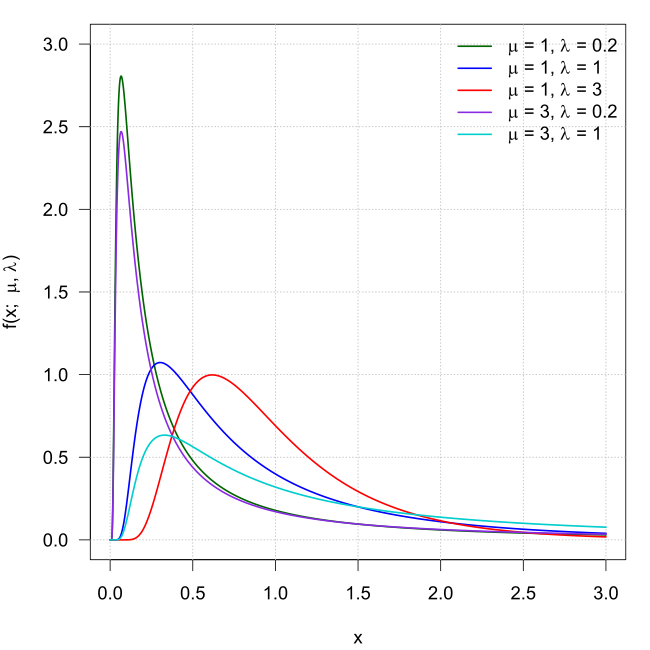
Inverse Gaussian can be useful when modeling the market in extreme conditions (black swan events). When calculating VaR and ES, it models the return distribution in a market with a lot of shocks. It is also very useful when doing stress testing, with which we get a more reliable result.

Skew Normal Distribution

Skew Normal Distribution is an extension to normal distribution, introducing a shape parameter $\alpha$ to allow for skewness.

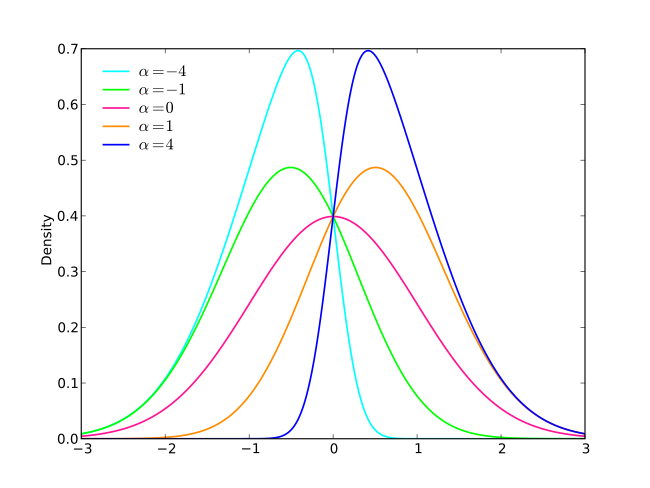

It can be useful for modeling returns with asymmetry distribution. It can also enhances regression for CAPM or other factor models, allowing for residuals with non-symmetric distribution.

# 4 & 5

In [23]:
# Subtract mean from returns
returns = np.log(df_price / df_price.shift(1)).dropna()
returns_hist = returns.loc[returns.index <= '2023-12-31'].copy()
returns_hist = returns_hist.subtract(returns_hist.mean(), axis=1)
returns_hist

,SPY,AAPL,NVDA,MSFT,AMZN,META,GOOGL,AVGO,TSLA,GOOG,...,SBUX,MMC,MDT,CB,LMT,KKR,MU,PLD,LRCX,EQIX
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04,0.006740,0.008507,0.024881,-0.046575,-0.010249,0.016676,-0.013543,0.009232,0.046636,-0.012913,...,0.035482,0.018684,0.033703,0.016147,-0.002057,0.027618,0.071140,0.036405,0.016453,0.025414
2023-01-05,-0.012430,-0.012416,-0.038353,-0.031932,-0.026306,-0.007570,-0.023380,-0.012269,-0.032812,-0.023926,...,-0.000174,-0.018899,-0.012017,-0.003912,0.001298,-0.017009,0.007221,-0.036559,-0.015916,-0.029998
2023-01-06,0.021722,0.034379,0.035811,0.009870,0.032698,0.019785,0.011333,0.055546,0.021010,0.014078,...,0.021524,0.028010,0.009978,0.023269,-0.007958,0.013973,0.034816,0.032332,0.062400,0.019099
2023-01-09,-0.001518,0.002326,0.045472,0.007843,0.012466,-0.008428,0.005950,-0.022714,0.054312,0.005419,...,-0.018333,-0.003929,-0.042265,-0.023816,-0.030472,0.027504,-0.009393,-0.005857,0.012901,0.009792
2023-01-10,0.006038,0.002692,0.012835,0.005742,0.026033,0.022636,0.002729,-0.006311,-0.011054,0.003128,...,0.012071,-0.000589,0.016921,0.005460,0.007266,0.007474,0.012824,-0.000872,0.010516,0.019467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.001057,-0.007318,-0.008257,0.000934,-0.005028,-0.006167,0.005786,-0.007629,-0.011074,0.004653,...,-0.000411,0.005175,-0.000828,0.003241,0.000548,-0.001494,0.009601,0.010149,0.000893,-0.003262
2023-12-26,0.003263,-0.004600,0.004167,-0.001632,-0.002359,-0.000122,-0.001593,0.005886,0.012645,-0.001114,...,0.004198,-0.002720,0.004288,0.005709,0.004466,0.000820,0.004423,0.007188,0.016902,0.004698
2023-12-27,0.000856,-0.001237,-0.002190,-0.003422,-0.002751,0.004231,-0.009964,-0.007974,0.015305,-0.011524,...,-0.003867,0.004783,0.001118,0.002626,-0.002589,0.011668,-0.006750,0.004594,-0.004032,0.002526


In [24]:
from scipy.stats import norm, t, skewnorm, norminvgauss


result = {}

for stock in returns_hist.columns:
    print(f"Fitting distributions for {stock}...")
    stock_data = returns_hist[stock].dropna()

    def fit_normal(data):
        params = norm.fit(data)
        ll = np.sum(norm.logpdf(data, *params))
        aic = 2 * len(params) - 2 * ll
        return {'params': params, 'll': ll, 'aic': aic}

    def fit_t(data):
        params = t.fit(data)
        ll = np.sum(t.logpdf(data, *params))
        aic = 2 * len(params) - 2 * ll
        return {'params': params, 'll': ll, 'aic': aic}

    def fit_skewnorm(data):
        params = skewnorm.fit(data)
        ll = np.sum(skewnorm.logpdf(data, *params))
        aic = 2 * len(params) - 2 * ll
        return {'params': params, 'll': ll, 'aic': aic}

    def fit_norminvgauss(data):
        params = norminvgauss.fit(data)
        ll = np.sum(norminvgauss.logpdf(data, *params))
        aic = 2 * len(params) - 2 * ll
        return {'params': params, 'll': ll, 'aic': aic}

    result[stock] = {
        'norm': fit_normal(stock_data),
        't': fit_t(stock_data),
        'skewnorm': fit_skewnorm(stock_data),
        'norminvgauss': fit_norminvgauss(stock_data)
    }

display(result)
    

Fitting distributions for SPY...
Fitting distributions for AAPL...
Fitting distributions for NVDA...
Fitting distributions for MSFT...
Fitting distributions for AMZN...
Fitting distributions for META...
Fitting distributions for GOOGL...
Fitting distributions for AVGO...
Fitting distributions for TSLA...
Fitting distributions for GOOG...
Fitting distributions for BRK-B...
Fitting distributions for JPM...
Fitting distributions for LLY...
Fitting distributions for V...
Fitting distributions for XOM...
Fitting distributions for UNH...
Fitting distributions for MA...
Fitting distributions for COST...
Fitting distributions for PG...
Fitting distributions for WMT...
Fitting distributions for HD...
Fitting distributions for NFLX...
Fitting distributions for JNJ...
Fitting distributions for ABBV...
Fitting distributions for CRM...
Fitting distributions for BAC...
Fitting distributions for ORCL...
Fitting distributions for MRK...
Fitting distributions for CVX...
Fitting distributions for KO...


{'SPY': {'norm': {'params': (np.float64(5.573408758158416e-20),
    np.float64(0.008223707296535633)),
   'll': np.float64(842.0671116390777),
   'aic': np.float64(-1680.1342232781553)},
  't': {'params': (np.float64(1149100043.2506266),
    np.float64(2.0768960602420644e-08),
    np.float64(0.008223718103296515)),
   'll': np.float64(842.0671116280703),
   'aic': np.float64(-1678.1342232561406)},
  'skewnorm': {'params': (np.float64(-0.6419048991711833),
    np.float64(0.00392862295483874),
    np.float64(0.009113935773891895)),
   'll': np.float64(842.1053705588208),
   'aic': np.float64(-1678.2107411176416)},
  'norminvgauss': {'params': (np.float64(385.97428248745763),
    np.float64(-130.1463394144785),
    np.float64(0.05285849568567336),
    np.float64(0.14757950980169018)),
   'll': np.float64(842.1097634177634),
   'aic': np.float64(-1676.2195268355267)}},
 'AAPL': {'norm': {'params': (np.float64(-1.1146817516316832e-19),
    np.float64(0.012524605728804835)),
   'll': np.floa

In [25]:
best_fit_models = {}


for stock, models in result.items():
    best_model = min(models.items(), key=lambda x: x[1]['aic'])
    best_fit_models[stock] = {
        'Model': best_model[0],
        'Parameters': best_model[1]['params']
    }

print(len(best_fit_models))

# Display the best fit models and their parameters
for stock, model_info in best_fit_models.items():
    print(f"Stock: {stock}")
    print(f"Best Fit Model: {model_info['Model']}")
    print(f"Parameters: {model_info['Parameters']}")
    print()

100
Stock: SPY
Best Fit Model: norm
Parameters: (np.float64(5.573408758158416e-20), np.float64(0.008223707296535633))

Stock: AAPL
Best Fit Model: t
Parameters: (np.float64(7.322068819646841), np.float64(-2.6480440454887786e-05), np.float64(0.010679805191820078))

Stock: NVDA
Best Fit Model: t
Parameters: (np.float64(5.113166225558643), np.float64(-0.0014719520005609743), np.float64(0.021811002972574683))

Stock: MSFT
Best Fit Model: t
Parameters: (np.float64(8.060684873955456), np.float64(-0.00020043763567572265), np.float64(0.0136456192915969))

Stock: AMZN
Best Fit Model: t
Parameters: (np.float64(5.979974468331601), np.float64(-0.00018303852167479684), np.float64(0.016878723671842573))

Stock: META
Best Fit Model: t
Parameters: (np.float64(4.3766570850200175), np.float64(-0.0014513669790365367), np.float64(0.015730758048864348))

Stock: GOOGL
Best Fit Model: t
Parameters: (np.float64(4.429084512834611), np.float64(-9.566956981451372e-05), np.float64(0.014162777821186821))

Stock: A

In [26]:
from mylib import var, es, varesSimCopula

pf_names.remove('all')

# Calculate VaR and ES for each portfolio
portfolio_var_es = {}



for pf_name in pf_names:
    pf_stocks = list(portfolios[pf_name]['Symbol'].copy())
    pf = portfolios[pf_name]
    # Calculate the weights of each stock in the portfolio
    holdings = pf.set_index('Symbol')['Holding']
    prices = df_price.loc['2023-12-29', pf_stocks]
    portfolio_value = (holdings * prices).sum()
    weights_pf = (holdings * prices) / portfolio_value
        
    u = pd.DataFrame(columns = pf_stocks)
    n_sim = 2000
    for stock in pf_stocks:
        if best_fit_models[stock]['Model'] == 'norm':
            u[stock] = stats.norm.cdf(returns_hist[stock], loc=best_fit_models[stock]['Parameters'][0], scale=best_fit_models[stock]['Parameters'][1])
        elif best_fit_models[stock]['Model'] == 't':
            u[stock] = stats.t.cdf(returns_hist[stock], df=best_fit_models[stock]['Parameters'][0], loc=best_fit_models[stock]['Parameters'][1], scale=best_fit_models[stock]['Parameters'][2])
        elif best_fit_models[stock]['Model'] == 'skewnorm':
            u[stock] = stats.skewnorm.cdf(returns_hist[stock], a=best_fit_models[stock]['Parameters'][0], loc=best_fit_models[stock]['Parameters'][1], scale=best_fit_models[stock]['Parameters'][2])
        elif best_fit_models[stock]['Model'] == 'norminvgauss':
            u[stock] = stats.norminvgauss.cdf(returns_hist[stock], a=best_fit_models[stock]['Parameters'][0], b=best_fit_models[stock]['Parameters'][1], loc=best_fit_models[stock]['Parameters'][2], scale=best_fit_models[stock]['Parameters'][3])
    r = u.corr()
    copula = stats.multivariate_normal(mean=np.zeros(len(pf_stocks)), cov=r)
    sim_u = pd.DataFrame(stats.norm.cdf(copula.rvs(size=n_sim)), columns=pf_stocks)
    sim_ret = pd.DataFrame(columns=pf_stocks)
    for stock in pf_stocks:
        if best_fit_models[stock]['Model'] == 'norm':
            sim_ret[stock] = stats.norm.ppf(sim_u[stock], loc=best_fit_models[stock]['Parameters'][0], scale=best_fit_models[stock]['Parameters'][1])
        elif best_fit_models[stock]['Model'] == 't':
            sim_ret[stock] = stats.t.ppf(sim_u[stock], df=best_fit_models[stock]['Parameters'][0], loc=best_fit_models[stock]['Parameters'][1], scale=best_fit_models[stock]['Parameters'][2])
        elif best_fit_models[stock]['Model'] == 'skewnorm':
            sim_ret[stock] = stats.skewnorm.ppf(sim_u[stock], a=best_fit_models[stock]['Parameters'][0], loc=best_fit_models[stock]['Parameters'][1], scale=best_fit_models[stock]['Parameters'][2])
        elif best_fit_models[stock]['Model'] == 'norminvgauss':
            sim_ret[stock] = stats.norminvgauss.ppf(sim_u[stock], a=best_fit_models[stock]['Parameters'][0], b=best_fit_models[stock]['Parameters'][1], loc=best_fit_models[stock]['Parameters'][2], scale=best_fit_models[stock]['Parameters'][3])
        print(f"{stock} simulated using {best_fit_models[stock]['Model']}.")
        
    alpha = .05
    sim_pf_value = np.sum(holdings * (prices * sim_ret), axis = 1)
    pf_var = -np.quantile(sim_pf_value, alpha)
    pf_es = -sim_pf_value[sim_pf_value <= -pf_var].mean()

    def optimize_risk_parity(sim_ret: np.ndarray, alpha=0.05):
        n_assets = sim_ret.shape[1]

        def portfolio_es(weights):
            portfolio_returns = sim_ret @ weights
            var_threshold = np.quantile(portfolio_returns, alpha)
            es = -portfolio_returns[portfolio_returns <= var_threshold].mean()
            return es

        def component_es(weights):
            base_es = portfolio_es(weights)
            ces = np.zeros(n_assets)
            epsilon = 1e-4
            for i in range(n_assets):
                w_bumped = weights.copy()
                w_bumped[i] += epsilon
                bumped_es = portfolio_es(w_bumped)
                ces[i] = weights[i] * (bumped_es - base_es) / epsilon
            return ces

        def sse_ces(weights):
            ces = component_es(weights)
            return np.sum((ces - ces.mean()) ** 2)

        constraints = ({
            'type': 'eq',
            'fun': lambda w: np.sum(w) - 1
        })
        bounds = [(0.0, 1.0) for _ in range(n_assets)]
        init_guess = np.full(n_assets, 1.0 / n_assets)

        res = minimize(sse_ces, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

        if res.success:
            w_opt = res.x
            final_ces = component_es(w_opt)
            total_es = portfolio_es(w_opt)
            return {
                'weights': w_opt,
                'component_es': final_ces,
                'total_es': total_es
            }
        else:
            raise RuntimeError("Optimization failed: " + res.message)
    
    result = optimize_risk_parity(sim_ret.values, alpha=0.05)

    print("Optimization for", pf_name)
    print("Optimized Weights:", result['weights'])
    print("Component ES:", result['component_es'])
    print("Total ES:", result['total_es'])
    
    # Simulate portfolio returns using multivariate normal distribution
    cov_matrix = returns_hist[pf_stocks].cov()
    simulated_returns = np.random.multivariate_normal(
        mean=returns_hist[pf_stocks].mean(),
        cov=cov_matrix,
        size=n_sim
    )

    # Calculate VaR and ES
    alpha = 0.05
    simulated_returns_df = pd.DataFrame(simulated_returns, columns=pf_stocks)
    sim_pf_value_mv = np.sum(holdings * (prices * simulated_returns_df), axis=1)
    pf_var_mv = -np.quantile(sim_pf_value_mv, alpha)
    pf_es_mv = -sim_pf_value_mv[sim_pf_value_mv <= -pf_var].mean()

    portfolio_var_es[pf_name] = {
        'VaR': pf_var,
        'ES': pf_es,
        'VaRMv': pf_var_mv,
        'ESMv': pf_es_mv,
    }
    
    capm_results = all_capm_results_df.loc[all_capm_results_df['Symbol'].isin(pf_stocks)].copy()
    excess_returns = returns.subtract(df_rf['rf'], axis=0)
    excess_returns_mkt = returns['SPY'].subtract(df_rf['rf'], axis=0)
    start_date = '2024-01-02'
    df_pf_returns_holding_ar = df_price[pf_stocks].pct_change().dropna().copy()
    df_pf_returns_holding_ar = df_pf_returns_holding_ar.loc[df_pf_returns_holding_ar.index >= start_date].copy()
    df_pf_returns_holding_log = stock_returns.loc[returns.index >= start_date].copy()
    pf_excess_returns = excess_returns.loc[excess_returns.index >= start_date].copy()
    df_rf_holding = df_rf.loc[df_rf.index >= start_date].copy()
    mkt_premium_holding = excess_returns_mkt.loc[excess_returns_mkt.index >= start_date].copy()
    
    # Ex-post attribution
    weights = {}
    factor_weights = {}
    portfolio_returns = {}
    resid_returns = {}
    resid_returns_stocks = {}
    current_weights = result['weights']
    for date in df_pf_returns_holding_ar.index:
        # Calculate portfolio return for the day
        weights[date] = current_weights
        weighted_betas = capm_results['Beta'].values * current_weights
        factor_weight = np.sum(weighted_betas)
        factor_weights[date] = factor_weight
        daily_returns = df_pf_returns_holding_ar.loc[date, :].values
        weighted_returns = current_weights * (1 + daily_returns)
        pf_return = np.sum(weighted_returns)
        portfolio_returns[date] = pf_return - 1
        resid_returns[date] = (pf_return - 1) - factor_weight * mkt_premium_holding[date]
        resid_stocks = current_weights * daily_returns - weighted_betas * mkt_premium_holding[date]
        resid_returns_stocks[date] = resid_stocks
        current_weights = weighted_returns / pf_return
    resid_returns_stocks = pd.DataFrame.from_dict(resid_returns_stocks, orient='index', columns=pf_stocks)

    df_weights = pd.DataFrame(weights, index=pf_stocks).T
    df_factor_weights = pd.DataFrame.from_dict(factor_weights, orient='index', columns=['excess_return'])
    df_portfolio_returns = pd.DataFrame(portfolio_returns.values(), index=portfolio_returns.keys(), columns=['returns'])
    df_resid_returns = pd.DataFrame.from_dict(resid_returns, orient='index', columns=['resid_return'])
    portfolio_returns = df_portfolio_returns['returns']
    log_total_return = np.sum(np.log1p(portfolio_returns))
    total_return = np.exp(log_total_return) - 1
    
    
    result = {}
    total_return_market = np.exp(np.sum(mkt_premium_holding))-1
    total_return_alpha = np.exp(np.sum(df_resid_returns.values))-1
    result["Total Return"] = [total_return_market, total_return_alpha, total_return]
    
    K = log_total_return / total_return
    k_t = np.log1p(portfolio_returns) / portfolio_returns / K

    
    
    attr_matrix = mkt_premium_holding.values * df_factor_weights.values.T * k_t.values
    factor_return_attr = attr_matrix.sum(axis=1)[0]
    resid_return_attr = (df_resid_returns.values.T * k_t.values).sum(axis=1)[0]
    resid_return_stock_attr = resid_returns_stocks.mul(k_t.values, axis=0)
    # print the alpha of each stock
    # display(np.sum(resid_return_stock_attr, axis=0))

    result['Return Attribution'] = [factor_return_attr, resid_return_attr, factor_return_attr+resid_return_attr]
    
    # Volatility
    # Factors
    # SPY
    y = (mkt_premium_holding.values * df_factor_weights.values.T).flatten()
    X = portfolio_returns
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    component_sd = []
    component_sd.append(model.params.iloc[1])
    # Alpha
    y = df_resid_returns.values.flatten()
    model = sm.OLS(y, X).fit()
    component_sd.append(model.params.iloc[1])
    pf_vol = portfolio_returns.std()
    factor_vol_attr = component_sd[0] * pf_vol
    resid_vol_attr = component_sd[1] * pf_vol
    
    result['Vol Attribution'] = [factor_vol_attr, resid_vol_attr, pf_vol]
    result_df = pd.DataFrame.from_dict(result, orient='index', columns=['SPY', 'Alpha', 'Portfoliio'])
    display(result_df)
    
# Print the portfolio VaR and ES results
for pf_name, metrics in portfolio_var_es.items():
    print(f"Portfolio: {pf_name}")
    print(f"VaR (Simulated Copula): {metrics['VaR']:.2f}")
    print(f"ES (Simulated Copula): {metrics['ES']:.2f}")
    print(f"VaR (Multivariate Normal): {metrics['VaRMv']:.2f}")
    print(f"ES (Multivariate Normal): {metrics['ESMv']:.2f}")
    print()


WFC simulated using t.
ETN simulated using norminvgauss.
AMZN simulated using t.
QCOM simulated using t.
LMT simulated using t.
KO simulated using t.
JNJ simulated using t.
ISRG simulated using t.
XOM simulated using t.
MDT simulated using t.
DHR simulated using t.
PLD simulated using t.
BA simulated using t.
PG simulated using t.
MRK simulated using t.
AMD simulated using t.
BX simulated using t.
PM simulated using t.
SCHW simulated using t.
VZ simulated using t.
COP simulated using t.
ADI simulated using t.
BAC simulated using t.
NOW simulated using norminvgauss.
TMO simulated using t.
CVX simulated using t.
ANET simulated using t.
NVDA simulated using t.
GE simulated using norminvgauss.
GILD simulated using t.
MU simulated using norminvgauss.
CMCSA simulated using t.
DIS simulated using t.
Optimization for A
Optimized Weights: [0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0

,SPY,Alpha,Portfoliio
Total Return,0.198692,0.029657,0.229236
Return Attribution,0.197290,0.031946,0.229236
Vol Attribution,0.007688,0.000444,0.008132


AXP simulated using t.
HON simulated using t.
META simulated using t.
NFLX simulated using t.
PGR simulated using t.
LLY simulated using t.
JPM simulated using t.
VRTX simulated using t.
TJX simulated using t.
EQIX simulated using t.
AAPL simulated using t.
FI simulated using t.
DE simulated using t.
SBUX simulated using t.
GOOGL simulated using t.
T simulated using t.
ABT simulated using t.
BMY simulated using t.
MS simulated using t.
CRM simulated using t.
PFE simulated using t.
SPGI simulated using t.
BRK-B simulated using t.
ADBE simulated using t.
ACN simulated using t.
AMGN simulated using norminvgauss.
LIN simulated using t.
V simulated using t.
WMT simulated using t.
AMAT simulated using skewnorm.
CAT simulated using t.
RTX simulated using t.
UNP simulated using t.
Optimization for B
Optimized Weights: [0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303

,SPY,Alpha,Portfoliio
Total Return,0.198692,0.072582,0.255865
Return Attribution,0.177605,0.078261,0.255865
Vol Attribution,0.006412,0.000411,0.006822


IBM simulated using t.
TXN simulated using t.
ADP simulated using t.
GOOG simulated using t.
ORCL simulated using t.
BSX simulated using t.
UNH simulated using t.
TMUS simulated using norminvgauss.
SYK simulated using norminvgauss.
GS simulated using t.
UBER simulated using t.
AVGO simulated using norminvgauss.
MMC simulated using norminvgauss.
CSCO simulated using t.
PLTR simulated using norminvgauss.
MA simulated using t.
C simulated using t.
BKNG simulated using t.
MCD simulated using t.
LOW simulated using norminvgauss.
HD simulated using t.
INTU simulated using t.
LRCX simulated using norminvgauss.
KKR simulated using t.
COST simulated using t.
NEE simulated using t.
ABBV simulated using t.
TSLA simulated using t.
MSFT simulated using t.
PEP simulated using t.
CB simulated using t.
PANW simulated using t.
BLK simulated using t.
Optimization for C
Optimized Weights: [0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.030

,SPY,Alpha,Portfoliio
Total Return,0.198692,0.169674,0.397244
Return Attribution,0.212557,0.184687,0.397244
Vol Attribution,0.007803,0.001003,0.008806


Portfolio: A
VaR (Simulated Copula): 4357.78
ES (Simulated Copula): 5711.07
VaR (Multivariate Normal): 4091.16
ES (Multivariate Normal): 5249.42

Portfolio: B
VaR (Simulated Copula): 3866.07
ES (Simulated Copula): 5202.16
VaR (Multivariate Normal): 3616.32
ES (Multivariate Normal): 4763.97

Portfolio: C
VaR (Simulated Copula): 4184.55
ES (Simulated Copula): 5327.68
VaR (Multivariate Normal): 3491.43
ES (Multivariate Normal): 5009.36

